## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
import json

# helper functions

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512):
    for i in range(n_seg):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, time_first=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    plt.show()

def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.permute(0, 2, 1).flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_tsne(x, x_gen):
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    tsne = TSNE(n_components=2, verbose=1, perplexity=20)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_raw4subject_channel(xarray, sub=0, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

## DATA

In [2]:
# 1. DATA
import numpy as np
from pathlib import Path
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channel = 'O1'
filtering = False
time_dim = 512
n_subject = 20

# data
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject]).to_numpy()
# ch_list = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'Oz', 'F7', 'F8']
ch_list = [channel]
ch_ids = find_channel_ids(xarray, ch_list)
x = x[:, ch_ids, 440:]
if filtering:
    x = mne.filter.filter_data(x, 128, 1, None, method='fir', verbose=False)  # filter data
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 1, 3).flatten(0, 1)
sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
data = {'x': x, 'sub': sub}

## MODEL

In [134]:
from src.EEGModalNet.models.cWGAN_v3 import cWGAN_GP

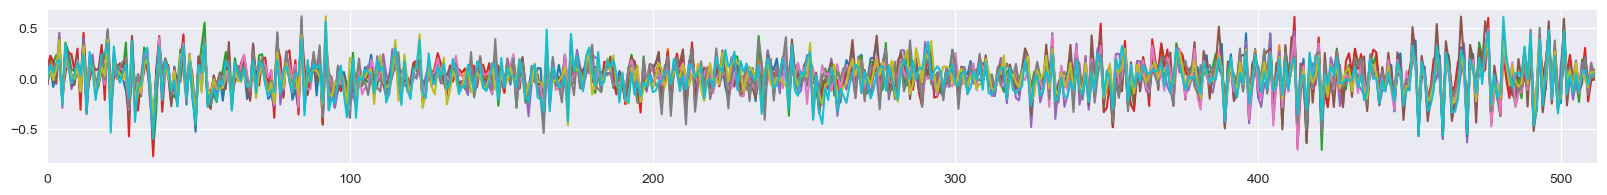

In [136]:
# 2. MODEL and Plot generated data by the model before training
latent_dim = 64
cwgan_gp = cWGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=latent_dim, n_subjects=n_subject)
noise = keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())
x_gen = cwgan_gp.generator(noise, torch.tensor(sub, device='mps')).cpu().detach().permute(0, 2, 1)
plot_overlap(x_gen, n_seg=10, start_from=20)

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


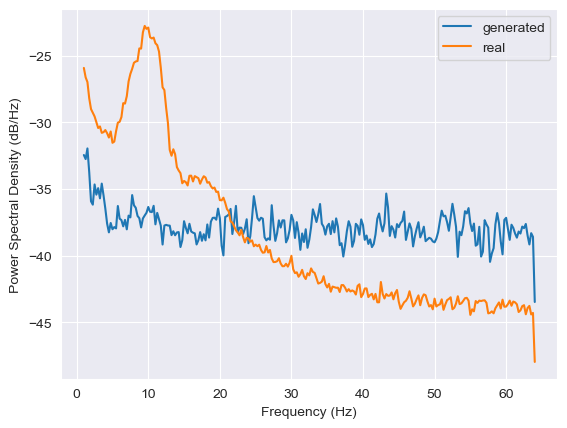

In [137]:
plot_psd(x_gen, fmin=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

## TRAINING

In [138]:
torch.cuda.empty_cache() # clear GPU memory before training
step_loss_history = StepLossHistory()

# 3. TRAINING
cwgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                 g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                 gradient_penalty_weight=1.0)

cwgan_gp.build(input_shape=(None, 1, time_dim))

In [144]:
# training
history = cwgan_gp.fit(data, epochs=10, batch_size=64, callbacks=[step_loss_history])

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - d_loss: 211.6185 - g_loss: 2.5250
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - d_loss: 341.4561 - g_loss: 4.5789
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - d_loss: 443.8037 - g_loss: 8.2441
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - d_loss: 1045.4227 - g_loss: 12.5394
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - d_loss: 1651.3893 - g_loss: 16.7686
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - d_loss: 3138.7920 - g_loss: 22.9904
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - d_loss: 5807.1509 - g_loss: 28.6545
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - d_loss: 11707.3750 - g_loss: 40.0853
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - d_loss: 22884.1016 - g_loss: 48.8650
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - d_loss: 42651.5625 - g_loss: 59.3822


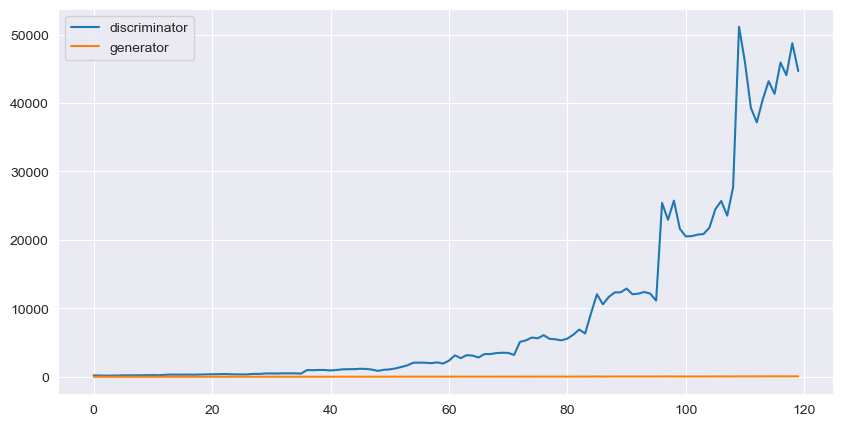

In [145]:
plot_step_losses(step_loss_history)

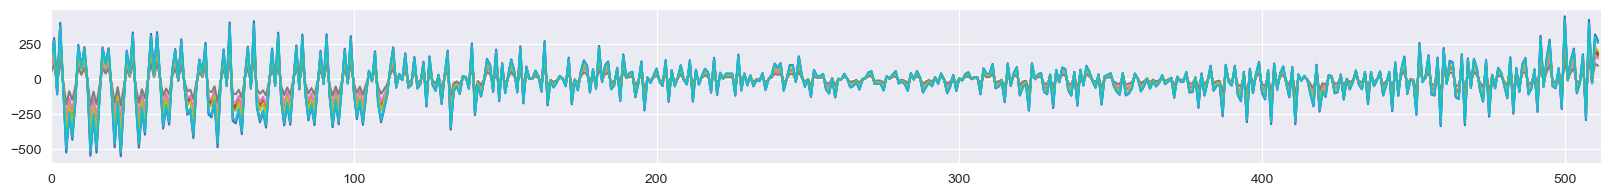

In [146]:
emb_layer = cwgan_gp.generator.emb_layer_g
gen_labels = torch.randint(0, n_subject, (len(x), 1)).to('mps')
noise = keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())

# train discriminator
fake_data = cwgan_gp.generator(noise, gen_labels).detach().cpu().permute(0, 2, 1)

plot_overlap(fake_data, n_seg=10, start_from=20)

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


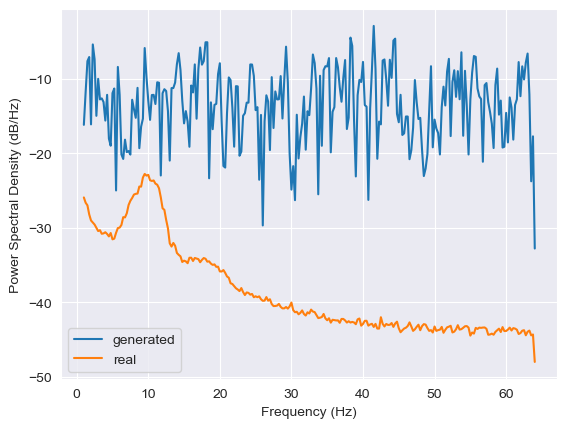

In [142]:
plot_psd(fake_data, fmin=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [143]:
fake_data = cwgan_gp.generator(noise, gen_labels).detach()
real_data = x.to(torch.float32).to('mps')
sub_labels = torch.tensor(sub).to('mps')
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(cwgan_gp.critic(fake_data, sub_labels).mean().item()), sigmoid(cwgan_gp.critic(real_data, sub_labels).mean().item())

(0.1216978972270767, 0.49682706243677055)

## DEBUG

In [3]:
import torch.nn as nn
# TODO: embedding layer for subjects
# TODO: is concatenating done correctly?
# TODO: residual connections, batch normalization, dropout, and transformer layers
sub = torch.tensor(sub)

In [34]:
weights = nn.Parameter(torch.randn(20, 1, 1))
onehot_subejct = torch.nn.functional.one_hot(sub, num_classes=20)
weights = weights.gather(0, onehot_subejct.view(-1, 1, 1).expand(-1, 1, 1))

In [4]:
embedding = nn.Embedding(num_embeddings=20, embedding_dim=20)
output = embedding(sub)

In [5]:
combined = torch.einsum('bji,bjk->bki', x, output)

In [6]:
combined.shape

torch.Size([2380, 20, 512])

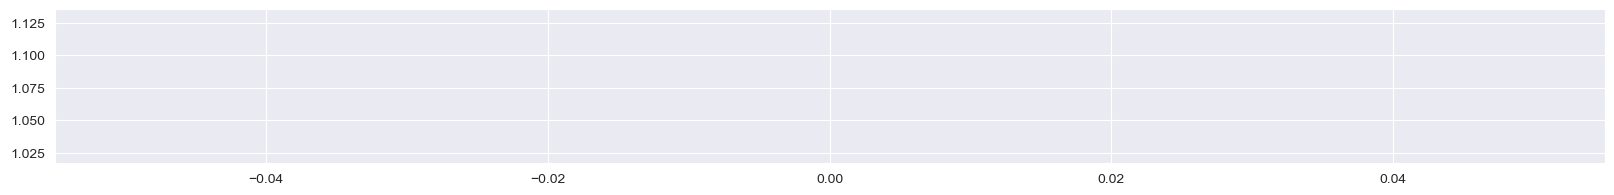

In [43]:
# visualize combined in relation to x
plt.figure(figsize=(20, 2))
# plt.plot(combined[0, :, 0].detach().cpu())
plt.plot(x[0, :, 0])
plt.show()

In [20]:
class SubjectLayers(nn.Module):
    """Per subject linear layer."""
    def __init__(self, n_subjects: int, emb_dim: int):
        super().__init__()
        self.sub_emb = nn.Embedding(n_subjects, emb_dim)

    def forward(self, x, subjects):
        weights = self.sub_emb(subjects)
        return torch.einsum("bct,bcd->bdt", x, weights)

torch.Size([2380, 1, 512])